# Classification model to segment customers based on account data

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
account_data = pd.read_csv('data/account_dim_20250325.csv')
fraud_data = pd.read_csv('data/fraud_claim_case_20250325.csv')
account_features = pd.read_csv('data/rams_batch_cur_20250325.csv')
statement_data = pd.read_csv('data/statement_fact_20250325.csv')


In [3]:
# Function to clean the RAMS dataset
def clean_rams(df):
    # Convert date column to datetime format
    df['cu_processing_date'] = pd.to_datetime(df['cu_processing_date'])

    # Keep only the latest processing date for each account
    latest_df = df.sort_values(by=['cu_processing_date'], ascending=False).drop_duplicates(subset=['cu_account_nbr'], keep='first')

    # drop the ca_cash_bal_pct_crd_line column
    df = df.drop(columns=['ca_cash_bal_pct_crd_line'])
    # irrelevant column as the values are all 0

    #drop the cu_nbr_days_dlq column
    df = df.drop(columns=['cu_nbr_days_dlq'])
    #redundant as theres a simialr column with months which is more useful

    #drop the ca_cash_bal_pct_cash_line column
    df = df.drop(columns=['ca_cash_bal_pct_cash_line'])

    #For all values in column cu_crd_bureau_scr , replace the value 0 with median of the column cu_crd_bureau_scr
    df['cu_crd_bureau_scr'] = df['cu_crd_bureau_scr'].replace(0, df['cu_crd_bureau_scr'].median())

    #drop the column cu_next_crd_line_rev_date
    df = df.drop(columns=['cu_next_crd_line_rev_date'])
    #irrelevant column as majority values are 0

    #dropping columns
    useless_col = [
        'cu_cur_balance',
        'ca_mob',
        'cu_rnd_nbr',
        'rb_crd_gr_new_crd_gr',
        'cu_processing_date',
        'mo_tot_sales_array_1',
        'mo_tot_sales_array_2',
        'mo_tot_sales_array_3',
        'mo_tot_sales_array_4',
        'mo_tot_sales_array_5',
        'mo_tot_sales_array_6'
    ]

    #Droping the above generated columns
    df = df.drop(columns=useless_col)

    # for the values 999999999999999 in cu_cash_line_am replace them with 20% of corresponding valur of cu_crd_bureau_scr column 
    df['cu_cash_line_am'] = df.apply(
        lambda row: row['cu_crd_bureau_scr'] * 0.2 if row['cu_cash_line_am'] == 999999999999999 else row['cu_cash_line_am'],
        axis=1
    )
    # round it off to 2 decimal places
    df['cu_cash_line_am'] = df['cu_cash_line_am'].round(2)

    #drop duplicate rows with duplicate values in the column cu_account_nbr
    df = df.drop_duplicates(subset=['cu_account_nbr'])

    return df

# Function to clean the account dataset
def clean_accounts(df):
    account_df = df.copy()

    # replace all \\\"\\\" values with NaN
    account_df.replace(r'\\\"', np.nan, regex=True, inplace=True)

    # drop duplicate rows
    account_df.drop_duplicates(inplace=True)
    
    # drop useless columns
    useless_column  = ['date_in_collection', # All values are null
                       'special_finance_charge_ind', # All values are null
                       'card_activation_date', # Redundant since we have card_activation_flag
                       'ebill_ind', # Not usefull for computing credit_line increase
                       'overlimit_type_flag', # All values are 0
                       'external_status_reason_code' # Redundant with ext_status_reason_cd_desc
                       ]
    account_df.drop(columns=useless_column, inplace=True, errors='ignore')

    # convert date columns to datetime
    date_columns = ['open_date']
    for col in date_columns:
        account_df[col] = pd.to_datetime(account_df[col], errors='coerce')

    # update the card_activation_flag to 0 or 1. Currently it has the following values: 0, 7, 8 and nan. 0 mean activated and the rest are not activated.
    account_df['card_activation_flag'] = account_df['card_activation_flag'].replace({'0': 1, '7': 0, '8': 0, np.nan: 0})

    # Create empty columns for each month
    for i in range(12):
        account_df[f"Month_{i+1}"] = account_df['payment_hist_1_12_mths'].apply(lambda x: x[i] if pd.notna(x) and i < len(x) else np.nan)

    for i in range(12):
        account_df[f"Month_{i+13}"] = account_df['payment_hist_13_24_mths'].apply(lambda x: x[i] if pd.notna(x) and i < len(x) else np.nan)

    # Drop the original payment history columns
    account_df.drop(columns=['payment_hist_1_12_mths', 'payment_hist_13_24_mths'], inplace=True)

    # Update the employee_code column. Currently it has the following values: H, Y and empty/na/null. Y mean employee, H means high spending customer and empty/na/null means normal customer. I want a separate column for high spending customer and employee. The rest are normal customers.
    account_df['high_spending_customer'] = account_df['employee_code'].replace({'H': 1, 'Y': 0, '': 0, np.nan: 0})
    account_df['employee_code'] = account_df['employee_code'].replace({'Y': 1, 'H': 0, '': 0, np.nan: 0})

    return account_df

# Clean fraud data
def clean_fraud_data(df):
    # Convert date columns to datetime
    df['reported_date'] = pd.to_datetime(df['reported_date'], errors='coerce')

    # create a new column which is set to 1 if fraud happened in the last 12 months and 0 otherwise
    df['fraud_last_12_months'] = df['reported_date'].apply(lambda x: 1 if (pd.to_datetime('today') - x).days <= 365 else 0)
    # create a new column which is set to 1 if fraud amount is greater than 1000 and 0 otherwise
    df['fraud_amount_gt_1000'] = df['gross_fraud_amt'].apply(lambda x: 1 if x > 1000 else 0)

    # drop all column except the current_account_nbr, fraud_last_12_months and fraud_amount_gt_1000
    df = df[['current_account_nbr', 'fraud_last_12_months', 'fraud_amount_gt_1000']]

    return df

def encode_month_in_accounts(df):
    # Define encoding dictionary
    encoding_dict = {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7,  # No Activity
        'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7,  # Debit-Only Activity
        'I': 0, 'J': 1, 'K': 2, 'L': 3, 'M': 4, 'N': 5, 'O': 6, 'P': 7,  # Credit-Only Activity
        '%': 0, '#': 0, '+': 0, '--': 0, 'z': 0, 'Q': 0, 'Z': 0  # Neutral risk indicators
    }
    month_columns = ['Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6','Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12','Month_13', 'Month_14', 'Month_15', 'Month_16', 'Month_17', 'Month_18','Month_19', 'Month_20', 'Month_21', 'Month_22', 'Month_23', 'Month_24']
    df[month_columns] = df[month_columns].astype(str)
    # Apply encoding only to month columns
    df[month_columns] = df[month_columns].applymap(lambda x: encoding_dict.get(x, 0))

    return df

account_data = clean_accounts(account_data)
account_data = encode_month_in_accounts(account_data)
account_features = clean_rams(account_features)
fraud_data = clean_fraud_data(fraud_data)


C:\Users\mohi2\AppData\Local\Temp\ipykernel_34640\866915542.py:81: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  account_df[col] = pd.to_datetime(account_df[col], errors='coerce')
C:\Users\mohi2\AppData\Local\Temp\ipykernel_34640\866915542.py:84: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  account_df['card_activation_flag'] = account_df['card_activation_flag'].replace({'0': 1, '7': 0, '8': 0, np.nan: 0})
C:\Users\mohi2\AppData\Local\Temp\ipykernel_34640\866915542.py:97: FutureWarning: 

In [4]:

# Merge datasets on the primary key (current_account_nbr)
merged_data = account_data.merge(statement_data, on="current_account_nbr", how="left") \
                          .merge(fraud_data, on="current_account_nbr", how="left") \
                          .merge(account_features, left_on="current_account_nbr", right_on="cu_account_nbr", how="left")
                        #   .merge(transaction_data, on="current_account_nbr", how="left") \

# Inspect merged data
print("Merged Data Shape:", merged_data.shape)

merged_data.head()


Merged Data Shape: (658685, 60)


,current_account_nbr,client_id,open_date,card_activation_flag,employee_code,pscc_ind,ext_status_reason_cd_desc,account_card_type,Month_1,Month_2,...,ca_current_utilz,cu_account_nbr,cu_line_incr_excl_flag,ca_max_dlq_lst_6_mnths,ca_mnths_since_active,ca_mnths_since_cl_chng,ca_nsf_count_lst_12_months,cu_otb,rb_new_bhv_scr,ca_avg_utilz_lst_3_mnths
0,nTgalbpd5Rsol7CA,YCTHAA278DC,2020-07-17 00:00:00-04:00,0.0,0.0,0,NaN,DUAL CARD,0,0,...,0.0,nTgalbpd5Rsol7CA,N,0.0,4.0,54.0,0.0,12900.0,742.0,0.0
1,nTgalbpd5Rsol7CA,YCTHAA278DC,2020-07-17 00:00:00-04:00,0.0,0.0,0,NaN,DUAL CARD,0,0,...,0.0,nTgalbpd5Rsol7CA,N,0.0,4.0,54.0,0.0,12900.0,742.0,0.0
2,nTgalbpd5Rsol7CA,YCTHAA278DC,2020-07-17 00:00:00-04:00,0.0,0.0,0,NaN,DUAL CARD,0,0,...,0.0,nTgalbpd5Rsol7CA,N,0.0,4.0,54.0,0.0,12900.0,742.0,0.0
3,nTgalbpd5Rsol7CA,YCTHAA278DC,2020-07-17 00:00:00-04:00,0.0,0.0,0,NaN,DUAL CARD,0,0,...,0.0,nTgalbpd5Rsol7CA,N,0.0,4.0,54.0,0.0,12900.0,742.0,0.0
4,nTgalbpd5Rsol7CA,YCTHAA278DC,2020-07-17 00:00:00-04:00,0.0,0.0,0,NaN,DUAL CARD,0,0,...,0.0,nTgalbpd5Rsol7CA,N,0.0,4.0,54.0,0.0,12900.0,742.0,0.0


In [5]:
# Define target labels for classification
def classify_accounts(row):
    if (
        row['ca_avg_utilz_lst_6_mnths'] < 30 and
        row['cu_cur_nbr_due'] == 0 and
        row['return_check_cnt_2yr'] == 0 and
        row['fraud_last_12_months'] == 0 and
        row['cu_crd_bureau_scr'] >= 740 and
        row['ca_max_dlq_lst_6_mnths'] == 0 and
        row['ca_mnths_since_active'] >= 6 and
        row['ca_mnths_since_cl_chng'] >= 6 and
        row['ca_nsf_count_lst_12_months'] == 0
    ):
        return "Eligible for Credit Line Increase without Risk"
    
    elif (
        0 <= row['ca_avg_utilz_lst_6_mnths'] <= 60 and
        0 <= row['cu_cur_nbr_due'] <= 1 and
        0 <= row['return_check_cnt_2yr'] <= 1 and
        0 <= row['fraud_last_12_months'] <= 1 and
        600 <= row['cu_crd_bureau_scr'] < 740 and
        0 <= row['ca_max_dlq_lst_6_mnths'] <= 1 and
        row['ca_mnths_since_active'] > 6 and
        row['ca_mnths_since_cl_chng'] > 6 and
        0 <= row['ca_nsf_count_lst_12_months'] <= 1 and
        row['fraud_amount_gt_1000'] == 0
    ):
        return "Eligible for Credit Line Increase with Risk"
    
    elif (
        row['ca_avg_utilz_lst_6_mnths'] > 60 or
        row['cu_cur_nbr_due'] > 1 or
        row['return_check_cnt_2yr'] > 1 or
        row['fraud_last_12_months'] > 1 or
        row['cu_crd_bureau_scr'] < 600 or
        row['ca_max_dlq_lst_6_mnths'] > 1 or
        row['ca_nsf_count_lst_12_months'] > 1 or
        row['fraud_amount_gt_1000'] > 0
    ):
        return "Non-Performing Account"
    
    else:
        return "No Credit Line Increase Required"


merged_data['Account_Segment'] = merged_data.apply(classify_accounts, axis=1)


In [6]:
# Encode target labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
merged_data['Account_Segment_Encoded'] = label_encoder.fit_transform(merged_data['Account_Segment'])

# filter out the rows with 0 as activation flag
merged_data = merged_data[merged_data['card_activation_flag'] == 1]

merged_data['Payment_Hist_Sum'] = merged_data.filter(like='Month_').sum(axis=1)
# Remove rows with all month columns
merged_data = merged_data.drop(columns=[f'Month_{i}' for i in range(1, 25)])



# Define features (X) and target (y)
features = [
            'Payment_Hist_Sum',
            'high_spending_customer',
            'return_check_cnt_2yr',
            'return_check_cnt_total',
            'fraud_last_12_months',
            'fraud_amount_gt_1000',
            'cu_bhv_scr',
            'cu_nbr_of_plastics',
            'ca_avg_utilz_lst_6_mnths',
            'cu_crd_bureau_scr',
            'cu_crd_line',
            'cu_cur_nbr_due',
            'ca_current_utilz',
            'ca_max_dlq_lst_6_mnths',
            'ca_mnths_since_active',
            'ca_mnths_since_cl_chng',
            'ca_nsf_count_lst_12_months',
            'rb_new_bhv_scr',
            'ca_avg_utilz_lst_3_mnths']
X = merged_data[features]
y = merged_data['Account_Segment_Encoded']

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       329
           1       0.99      1.00      1.00    151614
           2       0.97      0.96      0.97     20967

    accuracy                           0.99    172910
   macro avg       0.98      0.99      0.98    172910
weighted avg       0.99      0.99      0.99    172910

Confusion Matrix:
 [[   329      0      0]
 [    11 151039    564]
 [     0    761  20206]]


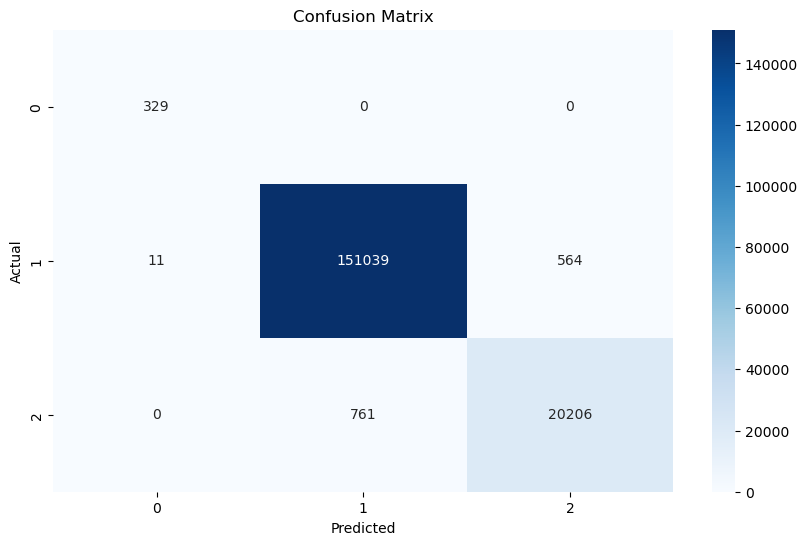

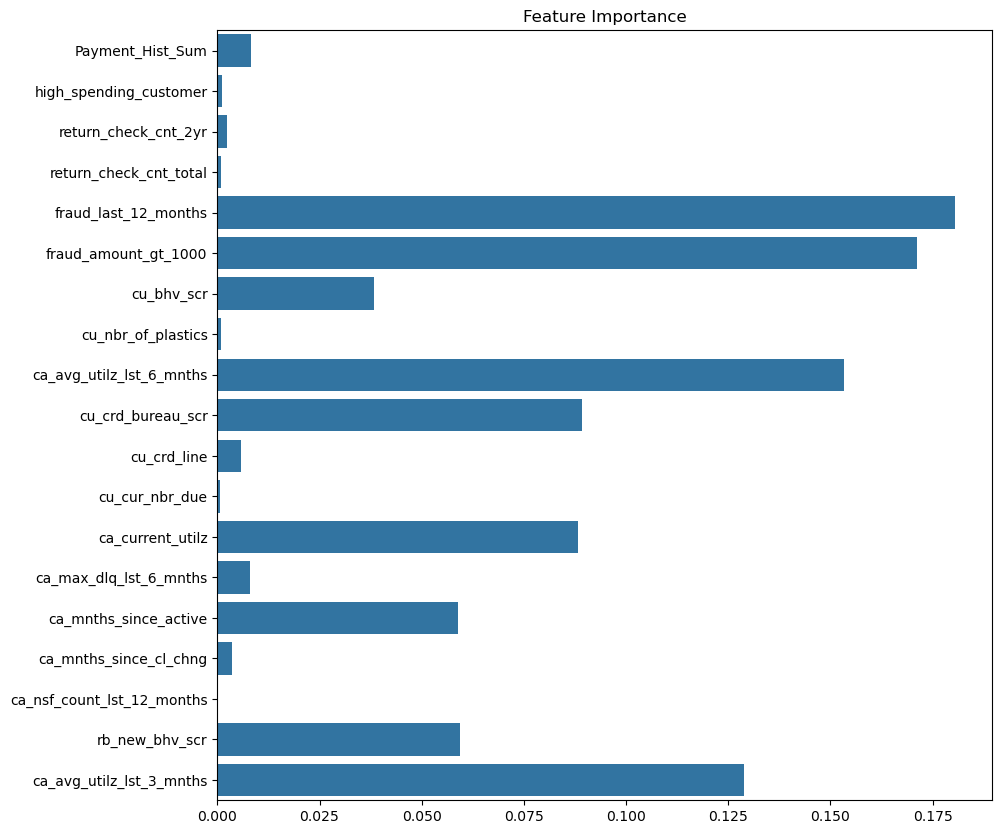

Sample Decoded Predictions: ['No Credit Line Increase Required' 'No Credit Line Increase Required'
 'Non-Performing Account' 'Non-Performing Account'
 'No Credit Line Increase Required' 'No Credit Line Increase Required'
 'No Credit Line Increase Required' 'No Credit Line Increase Required'
 'No Credit Line Increase Required' 'No Credit Line Increase Required']


In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier with hyperparameter tuning
rf_model = RandomForestClassifier(
    n_estimators=100,  # Increase the number of trees
    max_depth=5,      # Limit the depth of the trees to prevent overfitting
    min_samples_leaf=20,   # Minimum samples required to be at a leaf node
    max_features='sqrt',  # Use square root of features for best split
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize results
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Visualize feature importance
feature_importance = rf_model.feature_importances_
plt.figure(figsize=(10, 10))
sns.barplot(x=feature_importance, y=features)
plt.title("Feature Importance")
plt.show()

# Decode target labels for interpretation of predictions (optional)
decoded_predictions = label_encoder.inverse_transform(y_pred[:10])
print("Sample Decoded Predictions:", decoded_predictions)
